In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from lmfit.models import LinearModel
sns.set()

# Function for returning Field, Moment, Error, and Name

In [18]:
def getData(magrun):
    name = magrun.split('_')[4].split('.')[0]
    name = name.replace('P','.')
    f = np.genfromtxt(magrun, delimiter =',') #Opens the magrun file and creates an array using delimiter provided
    f = f[~np.isnan(f).any(axis=1)]
    T =f[:,1]
    TmeV = T
#     *.086 for K to meV
    H =f[:,2]
#     *.0001 for Oe to T
    E = f[:,4]
    Mom =f[:,3]
    return H, Mom, E, name

def emuToBohr(Mom,mass,molweight):
    newMom = []
    avo =6.0221409e+23 #part/mol
    bohr = 9.274e-21 #emu / Bohr magneton = erg/G/Bohrmag
    for i in Mom:
        newMom.append(i/(mass/molweight*avo*bohr))
    return newMom

def oeToTesla(H):
    newH = []
    for i in H:
        newH.append(i/10000)
    return newH

# Load in the M vs H data files

In [19]:
thisdir = os.getcwd()
runs = []
for i in os.listdir(thisdir):
    if i.endswith('.DAT'):
        runs.append(i)
comp = 'ErOI'
molweight = 310.16
mass = .0348

# Order the files by temperature
https://www.lenntech.com/calculators/molecular/molecular-weight-calculator.htm

In [20]:
runsorted = []
for i in runs:
    runsorted.append(i.split('_')[4].split('.')[0].split('P')[0])
   
runsorted = np.argsort([int(i) for i in runsorted])
runs = [runs[i] for i in runsorted]

# Plot all runs

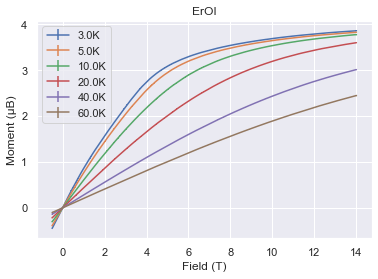

In [21]:
plt.figure()
data = {}
for i in runs:
    H, Mom, Err, name = getData(i)
    Mom = emuToBohr(Mom,mass,molweight)
    H = oeToTesla(H)
    Err = emuToBohr(Err,mass,molweight)
    data[name] = [H,Mom,Err]
    plt.errorbar(H,Mom, yerr = Err, label = name)

plt.title(comp)
plt.ylabel('Moment (\N{GREEK SMALL LETTER MU}B)')
plt.xlabel('Field (T)')
plt.legend()
plt.show()

# Choose a run to fit for saturation magnetization

In [22]:
temp = '3.0K'
curRun = data[temp]
H = curRun[0]
Mom = curRun[1]
Err = curRun[2]

# Choose your field range to fit over.

In [23]:
fieldRange = [7,14]
newH = []
newMom = []
newErr = []
for i in range(len(curRun[0])):
    if (H[i] >= fieldRange[0] and H[i] <= fieldRange[1]):
        newH.append(H[i])
        newMom.append(Mom[i])
        newErr.append(Err[i])
        
# plt.plot(newH,newMom)
# plt.show()

# Create the linear model and fit to the data over desired range

In [24]:
linModel = LinearModel()
# print(linModel.param_names)
params = linModel.guess(newMom, x = newH)
fitted = linModel.fit(newMom, x = newH, weights = newErr)
# fitted = linModel.fit(Mom, x = H, weights = Err)

fitted.params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
intercept     3.109     -inf      inf 0.003665     True     None     None
slope       0.05605     -inf      inf 0.0003321     True     None     None


# Create a full length line using the fitted parameters

In [25]:
MomLine = []
for i in H:
    MomLine.append(fitted.params['slope'].value*i + fitted.params['intercept'].value)

# Plot the data and the fit

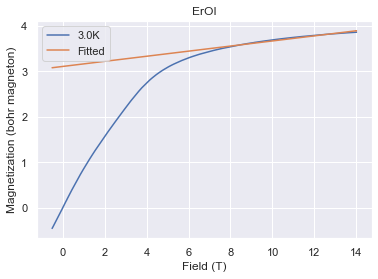

Saturation magnetization =  3.109 bohr magneton


In [26]:
plt.plot(H,Mom, label = temp)
# plt.plot(H,fitted.best_fit)
# plt.plot(newH,fitted.best_fit)
plt.plot(H,MomLine, label = 'Fitted')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (bohr magneton)')
plt.legend()
plt.title(comp)
plt.show()

print('Saturation magnetization =  {:.3f} bohr magneton'.format(fitted.params['intercept'].value))